In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from datacleaner import autoclean
import klib
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, f1_score, precision_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

Data Loading and Initial Exploration

In [2]:
df = pd.read_csv(r"C:\Users\Saidabrorkhon\ML_Lectures\ML 2nd month\datasets\Tweets.csv")

In [ ]:
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [ ]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

Data Preprocessing

In [4]:
missing_percentage = df.isnull().mean() * 100
missing_percentage

tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.308743
negativereason_confidence       28.128415
airline                          0.000000
airline_sentiment_gold          99.726776
name                             0.000000
negativereason_gold             99.781421
retweet_count                    0.000000
text                             0.000000
tweet_coord                     93.039617
tweet_created                    0.000000
tweet_location                  32.329235
user_timezone                   32.923497
dtype: float64

In [ ]:
threshold = 60
columns_to_drop = missing_percentage[missing_percentage > threshold].index
df.drop(columns_to_drop, inplace=True, axis=1)


GridSpec(6, 6)

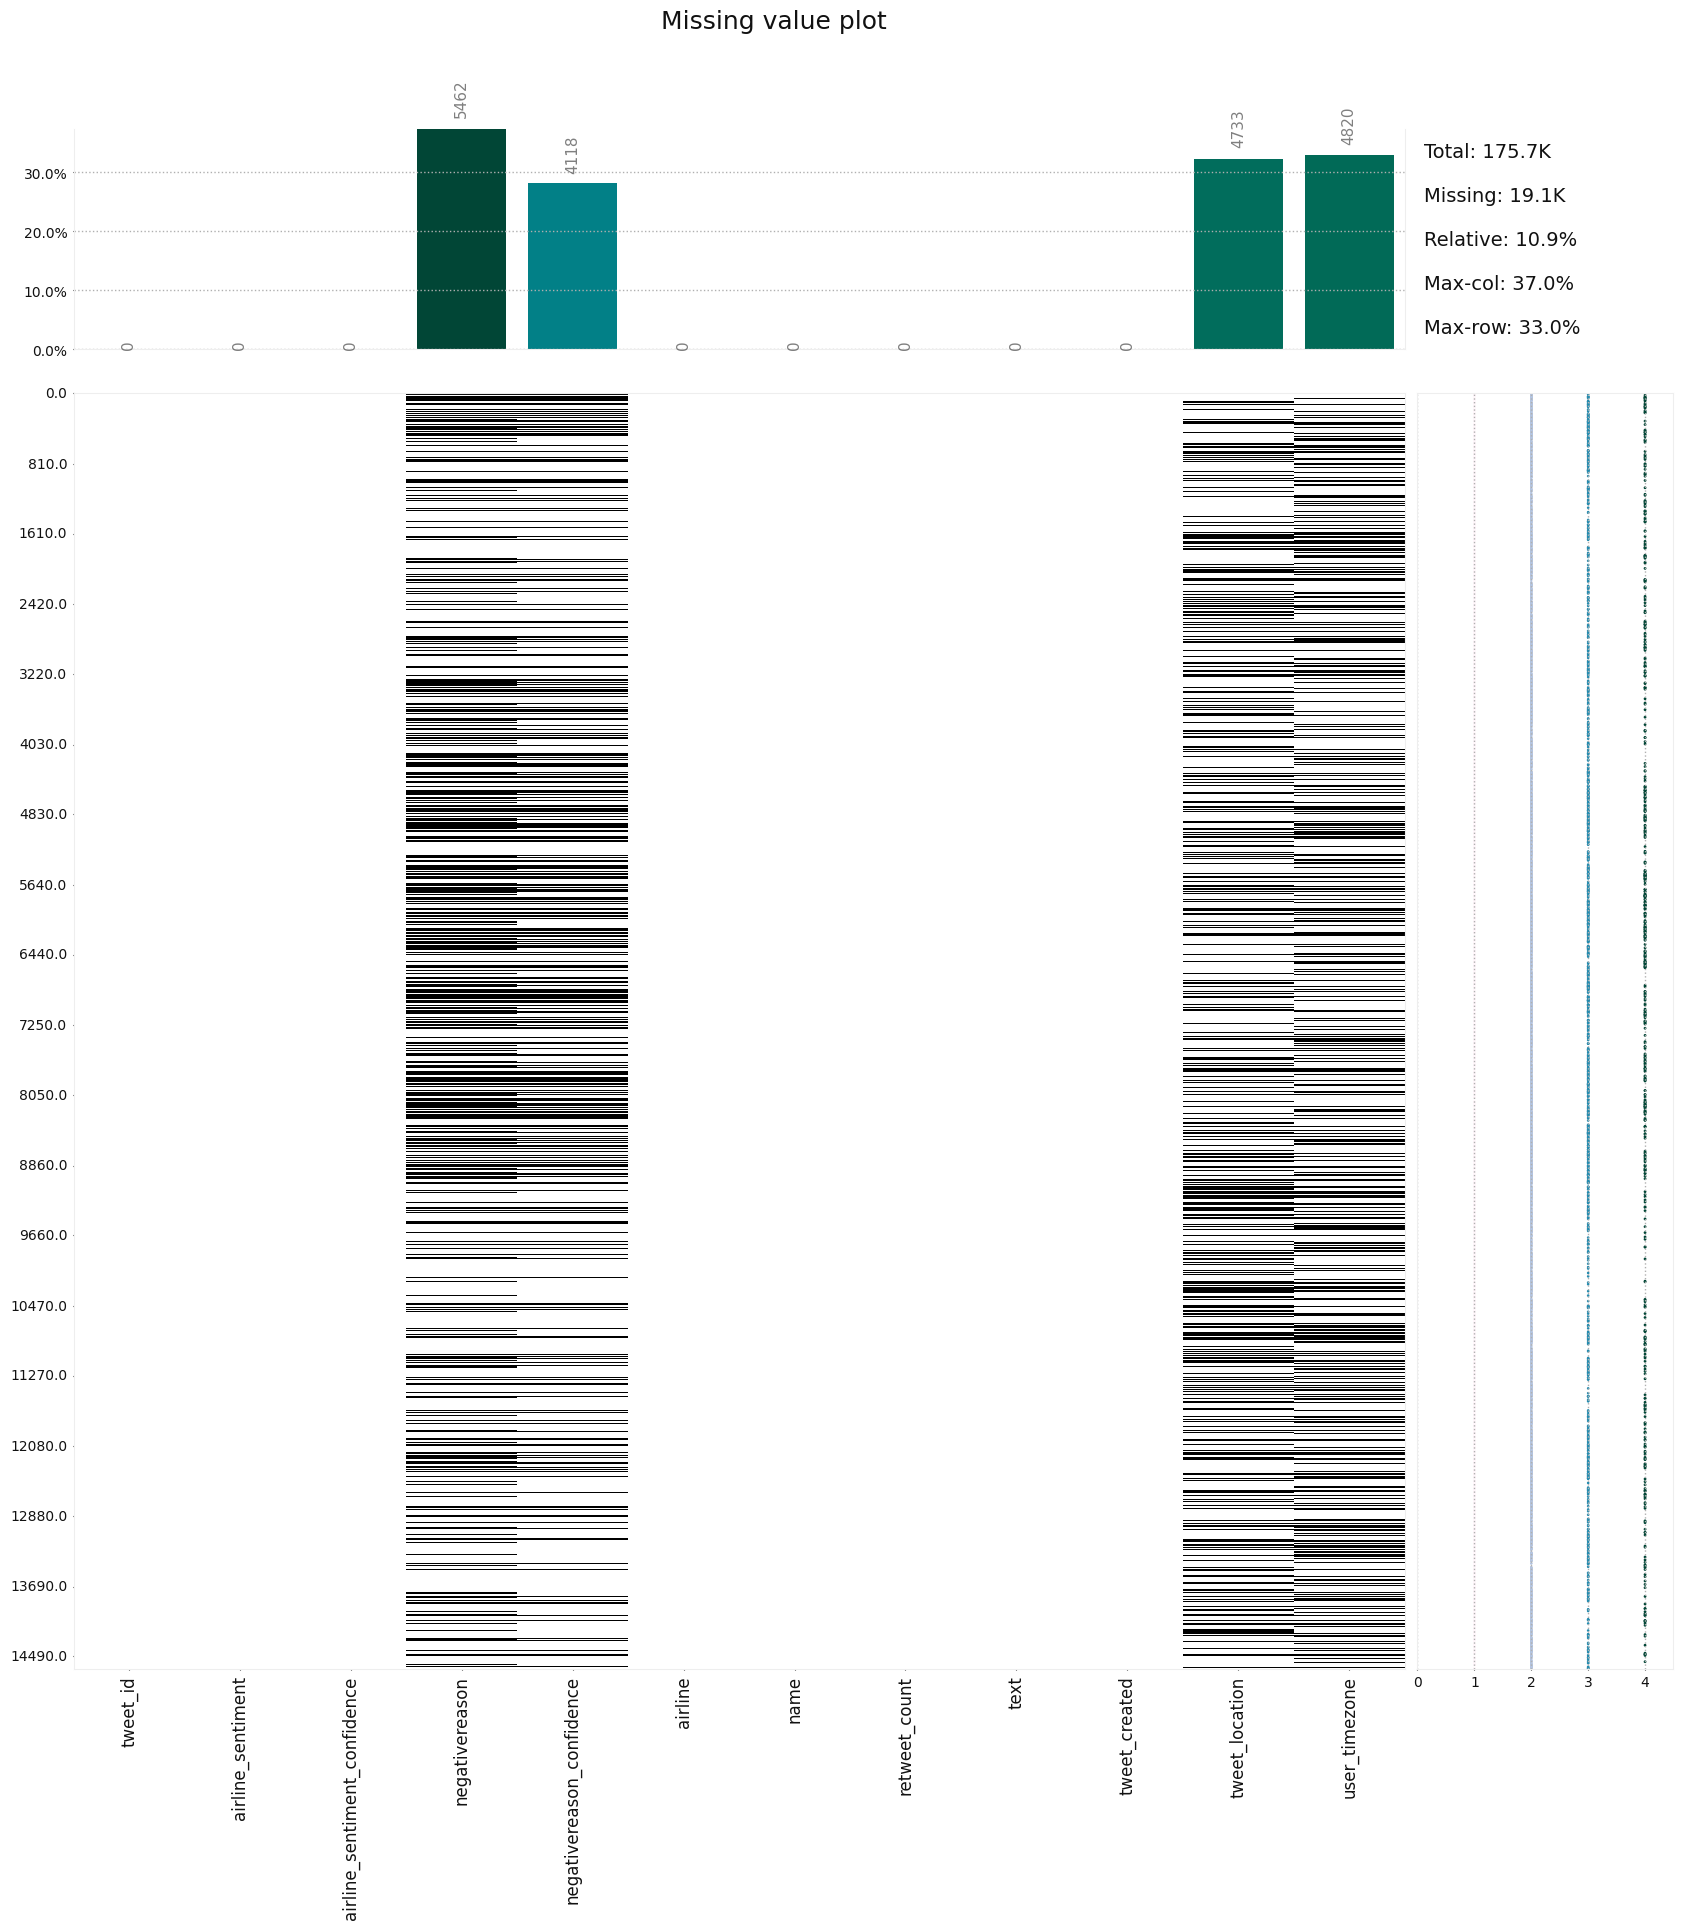

In [ ]:
klib.missingval_plot(df)

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<Axes: xlabel='retweet_count', ylabel='Density'>

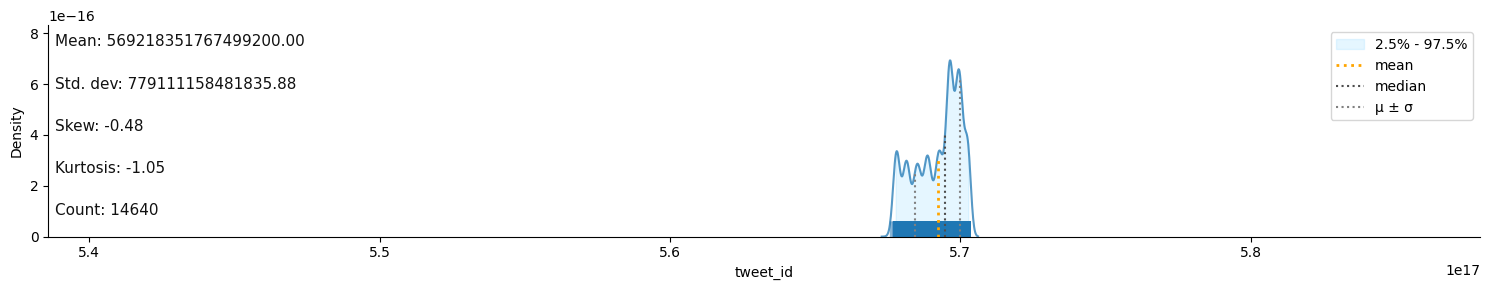

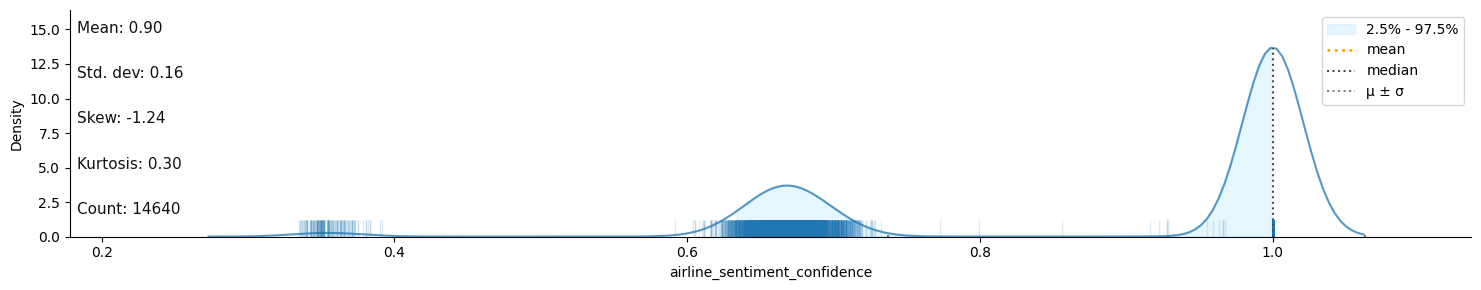

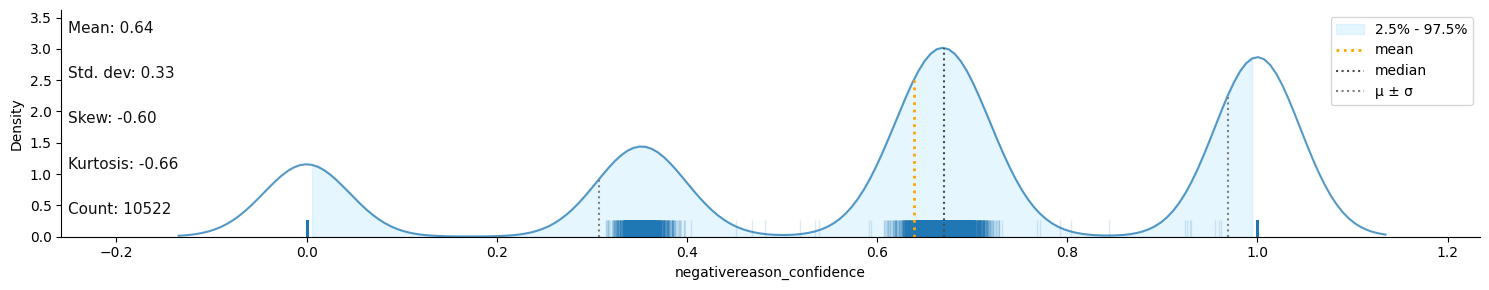

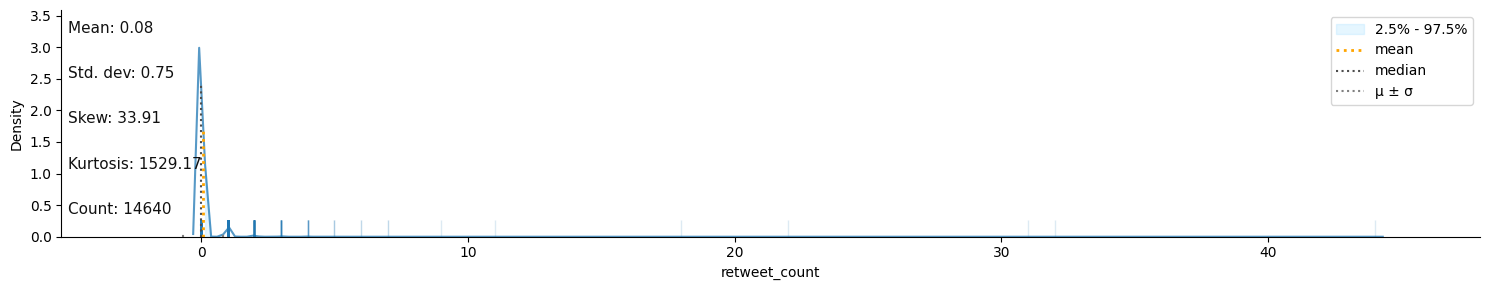

In [ ]:
klib.dist_plot(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   name                          14640 non-null  object 
 7   retweet_count                 14640 non-null  int64  
 8   text                          14640 non-null  object 
 9   tweet_created                 14640 non-null  object 
 10  tweet_location                9907 non-null   object 
 11  user_timezone                 9820 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 1.3+ MB


Feature transformation and Feature engineering

In [3]:
df['tweet_created'] = df['tweet_created'].astype(str)
df['tweet_created'] = pd.to_datetime(df['tweet_created'], errors='coerce')

In [4]:
df['year'] = df['tweet_created'].dt.year
df['month'] = df['tweet_created'].dt.month
df['day'] = df['tweet_created'].dt.day

In [62]:
df['retweet_count_log'] = np.log1p(df['retweet_count'])
df['negativereason_gold'] = np.log1p(df['negativereason_gold'])
df['airline_sentiment_confidence'] = np.power(df['airline_sentiment_confidence'],2)

In [43]:
df.drop(['airline_sentiment_gold'], axis=1, inplace=True)

In [63]:
numeric_cols = df.select_dtypes(include='number').columns
for col in numeric_cols:
  df[col] = np.log1p(df[col])

In [61]:
numeric_cols = df.select_dtypes(include='number').columns
skewness = df[numeric_cols].skew().sort_values(ascending=False)
print(skewness)

airline_sentiment                      inf
airline_sentiment_confidence    101.212644
negativereason_gold              36.406810
retweet_count                     4.090702
retweet_count_log                 4.056876
tweet_coord                       3.922813
user_timezone                     1.145628
negativereason                    0.864240
negativereason_confidence         0.606241
airline                          -1.023457
day                              -1.064378
name                             -4.036387
text                             -4.697100
tweet_location                   -5.055762
tweet_id                         -5.897518
dtype: float64


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14122 entries, 0 to 14121
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14122 non-null  float32
 1   airline_sentiment_confidence  14122 non-null  float32
 2   negativereason                14122 non-null  float32
 3   negativereason_confidence     14122 non-null  float32
 4   airline                       14122 non-null  float32
 5   name                          14122 non-null  float32
 6   negativereason_gold           14122 non-null  float32
 7   retweet_count                 14122 non-null  float32
 8   text                          14122 non-null  float32
 9   tweet_coord                   14122 non-null  float32
 10  tweet_location                14122 non-null  float32
 11  user_timezone                 14122 non-null  float32
 12  day                           14122 non-null  float32
 13  r

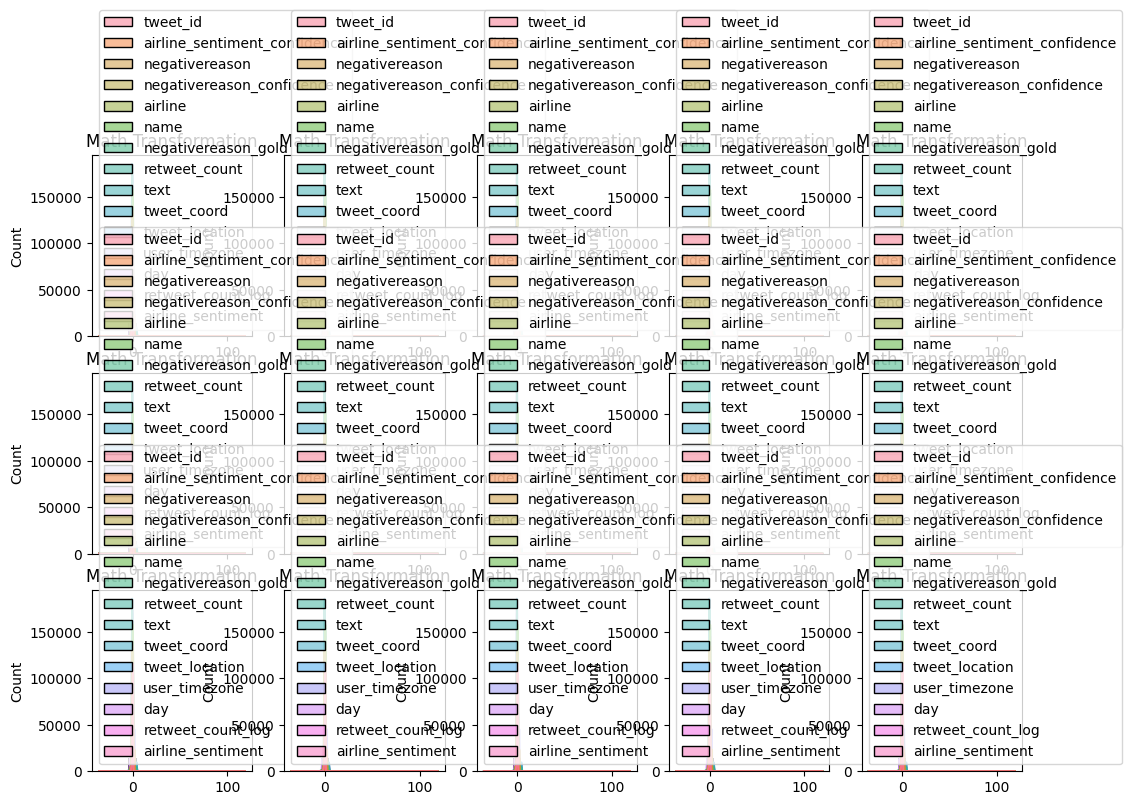

In [87]:
plt.figure(figsize=(12,8))
for i, col in enumerate(numeric_cols):
  plt.subplot(3,5,i+1)
  sns.histplot(df[numeric_cols], kde=True, bins=20)
  plt.title('Math Transformation')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype                    
---  ------                        --------------  -----                    
 0   tweet_id                      14640 non-null  int64                    
 1   airline_sentiment             14640 non-null  object                   
 2   airline_sentiment_confidence  14640 non-null  float64                  
 3   negativereason                9178 non-null   object                   
 4   negativereason_confidence     10522 non-null  float64                  
 5   airline                       14640 non-null  object                   
 6   name                          14640 non-null  object                   
 7   retweet_count                 14640 non-null  int64                    
 8   text                          14640 non-null  object                   
 9   tweet_created                 14640 non

In [5]:
df.drop(columns=['tweet_created'],inplace=True)

In [64]:
df = autoclean(df)
df = klib.data_cleaning(df) 

Shape of cleaned data: (14122, 15) - Remaining NAs: 0


Dropped rows: 480
     of which 480 duplicates. (Rows (first 150 shown): [5523, 5525, 5534, 5537, 5538, 5539, 5542, 5543, 5554, 5567, 5590, 5597, 5609, 5620, 5626, 5670, 5679, 5690, 5692, 5693, 5734, 5740, 5765, 5767, 5769, 5770, 5774, 5804, 5806, 5831, 5844, 5869, 5897, 5906, 5926, 5934, 5946, 5964, 5965, 5969, 5971, 5973, 5981, 5984, 5998, 6019, 6020, 6025, 6031, 6035, 6042, 6055, 6056, 6057, 6067, 6105, 6108, 6112, 6122, 6129, 6140, 6142, 6148, 6153, 6170, 6191, 6201, 6203, 6205, 6232, 6236, 6240, 6250, 6254, 6259, 6274, 6275, 6289, 6291, 6319, 6325, 6332, 6368, 6398, 6400, 6421, 6431, 6435, 6445, 6446, 6455, 6457, 6459, 6472, 6474, 6489, 6493, 6502, 6520, 6522, 6525, 6526, 6528, 6537, 6547, 6557, 6558, 6569, 6574, 6575, 6576, 6586, 6590, 6603, 6638, 6642, 6643, 6644, 6645, 6647, 6651, 6652, 6653, 6661, 6672, 6675, 6678, 6679, 6681, 6683, 6685, 6688, 6727, 6737, 7930, 7934, 7943, 7948, 7954, 7958, 7979, 7981, 7984, 7986, 7987, 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14602 entries, 0 to 14601
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14602 non-null  int64  
 1   airline_sentiment             14602 non-null  int8   
 2   airline_sentiment_confidence  14602 non-null  float32
 3   negativereason                14602 non-null  int8   
 4   negativereason_confidence     14602 non-null  float32
 5   airline                       14602 non-null  int8   
 6   airline_sentiment_gold        14602 non-null  int8   
 7   name                          14602 non-null  int16  
 8   negativereason_gold           14602 non-null  int8   
 9   retweet_count                 14602 non-null  int8   
 10  text                          14602 non-null  int16  
 11  tweet_coord                   14602 non-null  int16  
 12  tweet_location                14602 non-null  int16  
 13  u

In [7]:
for col in df.columns:
  if df[col].dtype == 'object':
    df[col].fillna(df[col].mode()[0], inplace=True)
  else:
    df[col].fillna(df[col].median(), inplace=True)

In [8]:
df['airline_sentiment'].value_counts().nunique

<bound method IndexOpsMixin.nunique of airline_sentiment
0    9157
1    3091
2    2354
Name: count, dtype: int64>

In [12]:
airline_sentiment_map = {'negative':0,'neutral':1, 'positive':2}
df['airline_sentiment'] = df['airline_sentiment'].map(airline_sentiment_map)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  int64  
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                14640 non-null  object 
 4   negativereason_confidence     14640 non-null  float64
 5   airline                       14640 non-null  object 
 6   name                          14640 non-null  object 
 7   retweet_count                 14640 non-null  int64  
 8   text                          14640 non-null  object 
 9   tweet_location                14640 non-null  object 
 10  user_timezone                 14640 non-null  object 
 11  year                          14640 non-null  int32  
 12  month                         14640 non-null  int32  
 13  d

In [9]:
for col in df.columns:
  if df[col].dtype == 'object':
     cardinality = df[col].nunique()
     if cardinality >= 5:
       le = LabelEncoder()
       df[col] = le.fit_transform(df[col])
     else:
      df = pd.get_dummies(df, columns=[col], drop_first=True, dtype=int)

In [10]:
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_location,user_timezone,day
0,570306133677760513,1,1.0000,3,0.6706,5,0,4049,4,0,10006,4,353,31,24
1,570301130888122368,2,0.3486,3,0.0000,5,0,5395,4,0,10157,4,353,62,24
2,570301083672813571,1,0.6837,3,0.6706,5,0,7678,4,0,9905,4,1219,27,24


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  int64  
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                14640 non-null  int64  
 4   negativereason_confidence     14640 non-null  float64
 5   airline                       14640 non-null  int64  
 6   name                          14640 non-null  int64  
 7   retweet_count                 14640 non-null  int64  
 8   text                          14640 non-null  int64  
 9   tweet_location                14640 non-null  int64  
 10  user_timezone                 14640 non-null  int64  
 11  year                          14640 non-null  int32  
 12  month                         14640 non-null  int32  
 13  d

In [67]:
x = df.drop(columns=['airline_sentiment'])
y = df['airline_sentiment']

sclaer = StandardScaler()
x_scaled = sclaer.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)
df = pd.concat([x_scaled, y.reset_index(drop=True)], axis=1)


In [12]:
df.head(3)

,tweet_id,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_location,user_timezone,day,airline_sentiment
0,1.401166,0.614219,-0.295637,0.084656,1.755103,-0.022438,0.082394,-0.012712,-0.110888,0.678142,-0.213925,-0.876683,-0.264271,1.411495,1
1,1.394738,-3.383170,-0.295637,-2.305692,1.755103,-0.022438,0.682437,-0.012712,-0.110888,0.714257,-0.213925,-0.876683,1.840368,1.411495,2
2,1.394677,-1.326791,-0.295637,0.084656,1.755103,-0.022438,1.700193,-0.012712,-0.110888,0.653985,-0.213925,0.127837,-0.535838,1.411495,1


Model selection

In [13]:
x = df.drop('airline_sentiment', axis=1)
y = df['airline_sentiment']

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size= 0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [14]:
y.unique

<bound method Series.unique of 0        1
1        2
2        1
3        0
4        0
        ..
14597    2
14598    0
14599    1
14600    0
14601    1
Name: airline_sentiment, Length: 14602, dtype: int8>

In [20]:
x_train.shape, x_test.shape, x_val.shape

((11681, 14), (1460, 14), (1461, 14))

In [21]:
y_train.shape, y_test.shape, y_val.shape

((11681,), (1460,), (1461,))

In [15]:
model = RandomForestClassifier()
rf_model = model.fit(x_train, y_train)

In [16]:
y_pred = rf_model.predict(x_test)

In [17]:
c_report = classification_report(y_pred, y_test)
print(c_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       940
           1       0.73      0.67      0.70       325
           2       0.52      0.59      0.55       195

    accuracy                           0.87      1460
   macro avg       0.75      0.75      0.75      1460
weighted avg       0.88      0.87      0.87      1460



In [36]:
from tabulate import tabulate

In [ ]:
headers = ["Label", "Precision", "Recall", "F1-Score", "Support"]
data = []

for label in ['0', '1', '2']:
    scores = c_report[label]
    row = [
        label,
        round(scores['precision'], 2),
        round(scores['recall'], 2),
        round(scores['f1-score'], 2),
        int(scores['support'])
    ]
    data.append(row)

for avg_type in ['macro avg', 'weighted avg']:
    scores = c_report[avg_type]
    row = [
        avg_type,
        round(scores['precision'], 2),
        round(scores['recall'], 2),
        round(scores['f1-score'], 2),
        int(scores['support'])
    ]
    data.append(row)

data.append(["accuracy", "", "", round(c_report['accuracy'], 2), ""])

table = tabulate(data, headers=headers, tablefmt="grid")
print(table)


+--------------+-------------+----------+------------+-----------+
| Label        | Precision   | Recall   |   F1-Score | Support   |
+==============+=============+==========+============+===========+
| 0            | 1.0         | 1.0      |       1    | 940       |
+--------------+-------------+----------+------------+-----------+
| 1            | 0.67        | 0.73     |       0.7  | 298       |
+--------------+-------------+----------+------------+-----------+
| 2            | 0.59        | 0.52     |       0.55 | 222       |
+--------------+-------------+----------+------------+-----------+
| macro avg    | 0.75        | 0.75     |       0.75 | 1460      |
+--------------+-------------+----------+------------+-----------+
| weighted avg | 0.87        | 0.87     |       0.87 | 1460      |
+--------------+-------------+----------+------------+-----------+
| accuracy     |             |          |       0.87 |           |
+--------------+-------------+----------+------------+--------

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, x, y, cv=kf, scoring='neg_mean_squared_error')
cv_scores = np.sqrt(-cv_scores)
print(cv_scores)
print(np.mean(cv_scores))
np.std(cv_scores)

[0.36726736 0.37964289 0.3788049  0.3890628  0.37562733]
0.37808105522465085


np.float64(0.007021663614896089)

In [33]:
headers = ['Method', 'Result']


data = [
  ["mean cv score", np.mean(cv_scores)]
]

for i, score in enumerate(cv_scores, 1):
    data.append([f"cv_score_{i}", score])

nk_table = tabulate(data, headers, tablefmt='grid')
print(nk_table)

+---------------+----------+
| Method        |   Result |
+===============+==========+
| mean cv score | 0.378081 |
+---------------+----------+
| cv_score_1    | 0.367267 |
+---------------+----------+
| cv_score_2    | 0.379643 |
+---------------+----------+
| cv_score_3    | 0.378805 |
+---------------+----------+
| cv_score_4    | 0.389063 |
+---------------+----------+
| cv_score_5    | 0.375627 |
+---------------+----------+
